# US-Airlines Dataset



This Jupyter notebook includes Dataset collected from the tweets of passengers about their flights with an American airline.

### So, in this notebook our aim is to predict these tweets sentiment, whther it's Positive, Negative or Neutral.



In [186]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# 1. Data Engineering

 At first, We start by fetching and inspecting the dataset

In [187]:
#Inspecting the data
tweets = pd.read_csv("Tweets.csv")
tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


<b>We investigate our dataset important attributes, In our case It's the Text attribute as Data and the Sentiment attribute as the label</b>

Start with the Target

In [188]:
count = tweets.airline_sentiment.value_counts()
print(count)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


<b>Then, We remove all the duplicates</b>

In [189]:
tweets = tweets.drop_duplicates(keep='first',subset='tweet_id') 

In [190]:
sentiment_counts = tweets.airline_sentiment.value_counts()
number_of_tweets = tweets.tweet_id.count()
print(sentiment_counts)

negative    9082
neutral     3069
positive    2334
Name: airline_sentiment, dtype: int64


<b> As you can see above, the values for each sentiment (Class) are not equal, hence, the dataset is not balanced.
Applying a model to unbalanced dataset results in a biased model toward the Class with most instances.

So, We have to balance the dataset, using Resampling. We chose Upsampling instead of downsampling because
We Don't have a lot of data. </b>

In [191]:
from sklearn.utils import resample
# Separate majority and minority classes
majority_class = tweets.loc[tweets.airline_sentiment=="negative"]
minority1_class = tweets.loc[(tweets.airline_sentiment=="neutral")]
minority2_class = tweets.loc[(tweets.airline_sentiment=="positive")] 

# Upsample minority class
minority_upsampled1 = resample(minority1_class, 
                                 replace=True,     # sample with replacement
                                 n_samples=9082) # majority instances
# Upsample minority class
minority_upsampled2 = resample(minority2_class, 
                                 replace=True,     # sample with replacement
                                 n_samples=9082) # majority instances
 
# Combine majority class with upsampled minority classes
upsampled = pd.concat([majority_class, minority_upsampled1, minority_upsampled2])
 
# Display new class counts
upsampled.airline_sentiment.value_counts()

neutral     9082
negative    9082
positive    9082
Name: airline_sentiment, dtype: int64

<b> Here comes the part where we need to prepare the data to be ready for the training.</b>

We need to download some plugins from the Natural language ToolKit to help us clean the data

In [192]:
import nltk
#nltk.download('punkt')
#nltk.download('wordnet')

<b> We create a Function that will clean the data as follows:</b>
1. Remove all the Symbols and keep the letters only (Remove @ at the beginning)
2. Remove the name of the Airline at the beginning of the Text
3. Set it all to lowercase
4. Remove all the Englosh stopping words
5. Lemmatize all the words (Get the original words)

In [193]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas


Apply the function to the Text attribute

In [194]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
upsampled['normalized_tweet'] = upsampled.text.apply(normalizer)
upsampled[['text','normalized_tweet']].head()

,text,normalized_tweet
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","[really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, recourse]"
4,@VirginAmerica and it's a really big bad thing about it,"[really, big, bad, thing]"
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,"[would, pay, flight, seat, playing, really, bad, thing, flying, va]"
15,@VirginAmerica SFO-PDX schedule is still MIA.,"[pdx, schedule, still, mia]"
17,@VirginAmerica I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!,"[flew, nyc, sfo, last, week, fully, sit, seat, due, two, large, gentleman, either, side, help]"


<b> Finally, We need to vectorize the text words into integer representation to help to the model to understand the data </b>

In [195]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

<b> We need to convert the Normalized tweets from list objects into strings, so the vectorizer would be able to deal with it </b>

In [196]:
upsampled.normalized_tweet = upsampled.normalized_tweet.tolist()

new_tweets = []
for tweet in upsampled.normalized_tweet:
    newtweet = " "
    new_tweets.append(newtweet.join(tweet))
upsampled.normalized_tweet = new_tweets
upsampled.normalized_tweet

3        really aggressive blast obnoxious entertainment guest face amp little recourse             
4        really big bad thing                                                                       
5        would pay flight seat playing really bad thing flying va                                   
15       pdx schedule still mia                                                                     
17       flew nyc sfo last week fully sit seat due two large gentleman either side help             
20       first fare may three time carrier seat available select                                    
24       guy messed seating reserved seating friend guy gave seat away want free internet           
25       match program applied three week called emailed response                                   
26       happened ur vegan food option least say ur site know able eat anything next hr fail        
28       get cold air vent vx noair worstflightever roasted sfotobos                       

<b> Apply the vectorizer </b>

In [197]:
vectorized_data = count_vectorizer.fit_transform(upsampled.normalized_tweet)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

<b> Change the targets from text into integer representation </b>

In [198]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
targets = upsampled.airline_sentiment.apply(sentiment2target)

# 2. Machine learning model

<b> Here we came to the part of modeling our dataset, We suggest using SVM and RandomForrest as classifiers for our 3 classes </b>

First, we split the dataset into training and testing dataset

In [199]:


from sklearn.model_selection import train_test_split
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train_index = data_train[:,0]
data_train = data_train[:,1:]
data_test_index = data_test[:,0]
data_test = data_test[:,1:]



# Classifier 1

Support vector machine proved it's effieiciency in classification data with small number of features

In [200]:
from sklearn import svm
clf1 = svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear')
clf1_output = clf1.fit(data_train, targets_train)

### Now we have reached the part of testing our model effeciency:
After a lot of thinking, we found that <b>accuracy</b> is the best metrics to evaluate this model. We don't need <b>precision or recall</b> because we don't prefer that all positive be true and some negative be mistaken as positive and we don't prefer the opposite, each prediction is important to us whther it's positively or negatively predicted, which leaves us with <b>F1 score or accuracy</b>. F1 would have been perfect if our dataset is not balanced, which is not the case in our dataset after doing the upsampling. So <b>accuracy</b> is the perfect metric for our problem, besides, we are going to draw a confusion matrix to examine the miss-classified instances.

In [201]:
clf1.score(data_test, targets_test)

0.8624644462794752

<b> Now let's try some Random examples </b>

In [202]:
sentences = count_vectorizer.transform([
    "This is a great flight I had so Much fun",
    "Thank you, The trip was great",
    "this is the worst trip I've ever had in my life, So bad",
    "Service was awful. I'll never fly with you again.",
    "I lost my luggage !! Don't fly with this shitty airline again",
    "I have no opinion,no bad or good feelings, this flight is normal",
])
prediction = clf1.predict_proba(sentences)

indecies = prediction.argmax(axis=1)
labels = []

for index in indecies:
    if index == 2:
        labels.append("positive")
    else:
        if index == 1:
            labels.append("neutral")
        else:
            labels.append("negative")



In [203]:
labels

['positive', 'positive', 'negative', 'negative', 'negative', 'positive']

<b> We can otice that our classifier predicted all the results successfully, But why There is still some miss-predictions with almost 15% of the data? 
 
We can draw the confusion matrix to know from where exactly this missclassification is coming

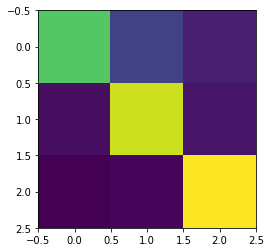

In [206]:
prediction1 = clf1.predict_proba(data_test)
prediction1 = prediction1.argmax(axis=1)
target_list = targets_test.tolist()


Confusion_Matrix =[x[:] for x in [[0] * 3] * 3]

for i in range(len(target_list)):
    temp = int(target_list[i])
    Confusion_Matrix[temp][prediction1[i]] = Confusion_Matrix[temp][prediction1[i]]+1

final = np.asarray(Confusion_Matrix)

plt.imsave("Confusion.jpg",final)



plt.imshow(Confusion_Matrix)

<b> From the confusion matrix, We can notice that many Negative class instances is classified as neutral and vice versa, and the positive class is almost perfect. This shows us the effectivness of the Upsampling we did at the phase of the data Engineering part to the positive class instances

# Classifier 2

Random Forest because it's highly robust to outliers, which will help avoid the class from being misleaded in classifying repeated words in different classes

imagne a word that appears many times in one class and few other times in other class.It originally belongs to the 1st class, and it's just an outlier in the 2nd class, Random Forest will be very helpful in avoiding this outlier.

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier

clf2 = OneVsOneClassifier(RandomForestClassifier(max_depth=500, random_state=0))
clf2.fit(data_train, targets_train)

OneVsOneClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=500,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None,
                                                    oob_s

In [214]:
clf2.score(data_test, targets_test)

0.8781539590788145

In [216]:
sentences = count_vectorizer.transform([
    "This is a great flight I had so Much fun",
    "Thank you, The trip was great",
    "this is the worst trip I've ever had in my life",
    "Service was awful. I'll never fly with you again.",
    "I lost my luggage !! Don't fly with this shitty airline again",
    "I have no opinion,no bad or good feelings, this flight is normal",
])
prediction = clf2.predict(sentences)
prediction

array([2, 2, 0, 0, 0, 1])

In [217]:
indecies = prediction
labels = []

for index in indecies:
    if index == 2:
        labels.append("positive")
    else:
        if index == 1:
            labels.append("neutral")
        else:
            labels.append("negative")




In [218]:
labels

['positive', 'positive', 'negative', 'negative', 'negative', 'neutral']

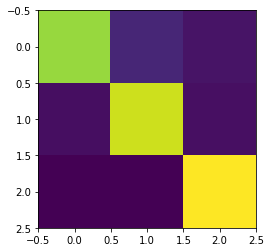

In [220]:
prediction1 = clf2.predict(data_test)

target_list = targets_test.tolist()


Confusion_Matrix =[x[:] for x in [[0] * 3] * 3]

for i in range(len(target_list)):
    temp = int(target_list[i])
    Confusion_Matrix[temp][prediction1[i]] = Confusion_Matrix[temp][prediction1[i]]+1

final = np.asarray(Confusion_Matrix)

plt.imsave("Confusion.jpg",final)



plt.imshow(Confusion_Matrix)

<b> From the confusion matrix, as the SVM,  We can notice that many Negative class instances is classified as neutral and vice versa But quite less than SVM, which shows some improvement 

<b>Finally, The weaknesses in this model is that some words are repeated in many classes of this dataset which makes it hard for the Machine learning model to classify it into the right class. Maybe Some extra data will enhance the results, because even if some words are repeated in many classes, of course it's going to be repeated more in the right class.

If we managed to gain some more data, at this point we can use Naive bayes for Multinomial. Because it's very good in classifying text datasets, as it assumes independence among data.